In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta
from sklearn.metrics import mean_squared_error

C:\Users\tamil\AppData\Local\Temp\ipykernel_8860\2838652306.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"],format="%d/%m/%Y %H:%M:%S")
C:\Users\tamil\AppData\Local\Temp\ipykernel_8860\2838652306.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Rounded_Timestamp"] = data["Timestamp"].dt.round("6h")
C:\Users\tamil\AppData\Local\Temp\ipykernel_8860\2838652306.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy

Water_Consumption    133
dtype: int64
                     Water_Consumption
Rounded_Timestamp                     
2024-01-01 06:00:00            1153.60
2024-01-01 12:00:00            1154.00
2024-01-01 18:00:00            1157.90
2024-01-02 00:00:00            1157.90
2024-01-02 06:00:00            1157.90
2024-01-02 12:00:00            1162.20
2024-01-02 18:00:00            1178.20
2024-01-03 00:00:00            1189.90
2024-01-03 06:00:00            1190.20
2024-01-03 12:00:00            1204.60
2024-01-03 18:00:00            1215.40
2024-01-04 00:00:00            1220.14
2024-01-04 06:00:00            1225.30
2024-01-04 12:00:00            1238.00
2024-01-04 18:00:00            1244.50
2024-01-05 00:00:00            1244.70
2024-01-05 06:00:00            1244.70
2024-01-05 12:00:00            1250.80
2024-01-05 18:00:00            1262.10
2024-01-06 00:00:00            1272.40


<Axes: xlabel='Rounded_Timestamp'>

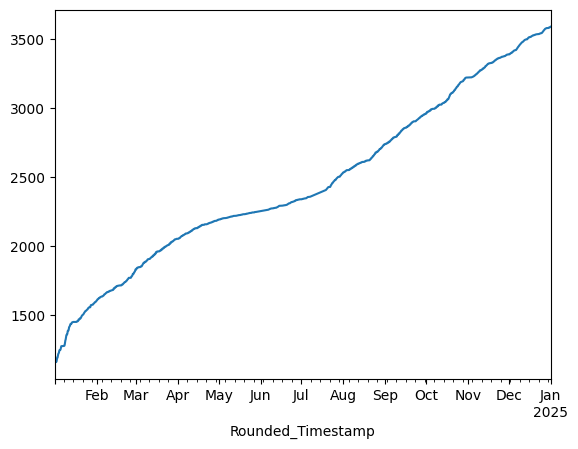

In [2]:
# Load dataset
water_usage = pd.read_csv('Water Usage/SOC Outlet-1/Table(1).csv',
                          usecols=["Date", "Time", "water_flow_in_litre", "water_flow_in_cubic_meter"])

# Reverse order if needed
data = water_usage[::-1]

# Set index and ensure DateTime format
data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"],format="%d/%m/%Y %H:%M:%S")
data["Rounded_Timestamp"] = data["Timestamp"].dt.round("6h")
#data = data.drop_duplicates(subset=["Rounded_Timestamp"], keep="first")  # Keep first occurrence
# Set the new Timestamp as index
data.set_index("Rounded_Timestamp", inplace=True)

# Drop the original "Date" and "Time" columns if no longer needed
data.drop(columns=["Date", "Time","Timestamp","water_flow_in_litre"], inplace=True)


# Ensure daily frequency
data = data.resample("6h").mean() 

# Rename column
data.rename(columns={'water_flow_in_cubic_meter': 'Water_Consumption'}, inplace=True)
print(data.isna().sum())
data.interpolate(method="linear", inplace=True)

# Compute water consumption as the difference between consecutive water flow values
#data["Water_Consumption"] = data["water_flow_in_litre"].diff()

# Drop the first row since it will have NaN (no previous value to subtract from)
data = data.dropna()

# Display first 20 rows
print(data.head(20))
data["Water_Consumption"].plot()

In [3]:

# Normalize the water consumption data
scaler = MinMaxScaler(feature_range=(0, 1))
data["Water_Consumption"] = scaler.fit_transform(data[["Water_Consumption"]])
original_timestamps = data.index  # Save timestamps before preprocessing

# Converts data into sequences for LSTM
def create_sequences(data, time_steps=10):
    """ Create input-output pairs for LSTM training. """
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])  # Use past 'time_steps' values as input
        y.append(data[i + time_steps])      # Predict the next value
    X, y = np.array(X), np.array(y)

    # Ensure 3D shape: (samples, time_steps, features=1)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y

# Define time steps (e.g., past 7 readings)
time_steps = 7
data_values=data["Water_Consumption"].values
X, y = create_sequences(data_values, time_steps)

# Print shape (should be 3D: samples, time_steps, features)
print("X shape:", X.shape)  # (num_samples, time_steps, 1)
print("y shape:", y.shape)  # (num_samples,)




X shape: (1457, 7, 1)
y shape: (1457,)


In [4]:
# Define split index (80% training, 20% testing)
train_size = int(len(X) * 0.8)

# Split into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Verify final shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (1165, 7, 1), y_train shape: (1165,)
X_test shape: (292, 7, 1), y_test shape: (292,)


In [5]:
def build_lstm_model(optimizer):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(7, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [6]:
optimizers = {
    "Adam": Adam(learning_rate=0.001),
    "SGD": SGD(learning_rate=0.001, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.0001),
    "Adagrad": Adagrad(learning_rate=0.001),
    "Adadelta": Adadelta(learning_rate=0.001)
}

In [7]:
import matplotlib.pyplot as plt

def plot_training_loss(history, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training Loss')
    plt.legend()
    plt.show()

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
def pred(model, X_test, y_test, scaler, original_timestamps):
    predictions = model.predict(X_test)
    
    # Reverse scaling
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    predicted_timestamps = original_timestamps[-len(predictions):]  # Match predictions with time
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    r2 = r2_score(y_test_actual, predictions)
    print(f"Test RMSE: {rmse:.2f}\n r2-score (closer to 1, more the model is preferred) : {r2}")
    #acc=100*(1-(rmse/len(y_test)))
    #print(f'Accuracy (ARIMA): {acc}')
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(predicted_timestamps,y_test_actual, label="Actual Water Demand")
    plt.plot(predicted_timestamps,predictions, label="Predicted Water Demand", linestyle="dashed")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Water Consumption")
    plt.title("LSTM Water Demand Forecasting")
    metrics_text = f"RMSE: {rmse:.2f}\nR² Score: {r2:.2f}"
    plt.text(0.05, 0.7, metrics_text, transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.show()


Training LSTM with Adam optimizer...


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.1474 - val_loss: 0.0052
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0053 - val_loss: 0.0025
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7229e-04 - val_loss: 9.9483e-04
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6303e-05 - val_loss: 5.0636e-04
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.6063e-06 - val_loss: 5.8058e-04
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.8799e-06 - val_loss: 5.7321e-04
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0360e-06 - val_loss: 5.0447e-04
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0916e-06 - val_loss: 5.2996e-04
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9971e-06 - val_loss: 4.5639e-04
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1230e-06 - val_loss: 4.9887e-04
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1997e-06 - val_loss: 4.

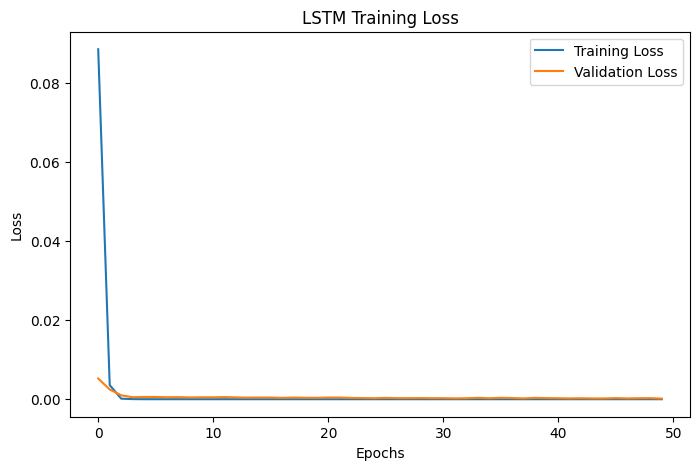

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step 
Test RMSE: 31.03
 r2-score (closer to 1, more the model is preferred) : 0.946469369317957


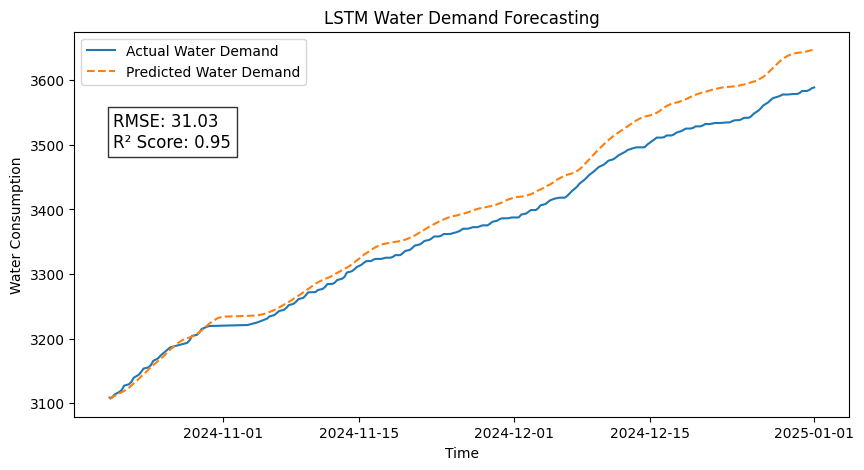


Training LSTM with SGD optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.1499 - val_loss: 0.2330
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0260 - val_loss: 0.1453
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0242 - val_loss: 0.1436
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0230 - val_loss: 0.1405
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0229 - val_loss: 0.1388
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0224 - val_loss: 0.1339
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0205 - val_loss: 0.1312
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0215 - val_loss: 0.1289
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0195 - val_loss: 0.1248
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0191 - val_loss: 0.1206
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0193 - val_loss: 0.1166
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0181 - val_l

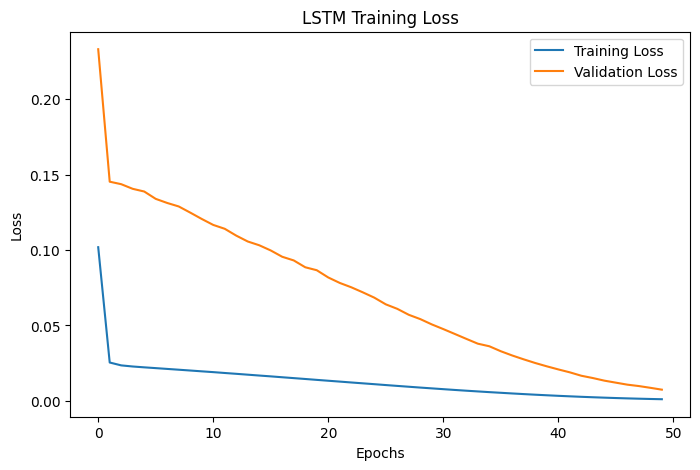

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step 
Test RMSE: 210.67
 r2-score (closer to 1, more the model is preferred) : -1.4679968075042944


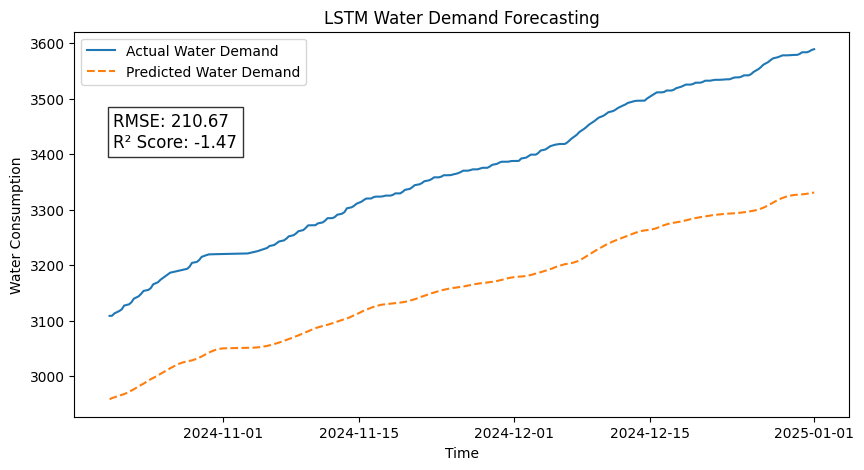


Training LSTM with RMSprop optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.2282 - val_loss: 0.7113
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1850 - val_loss: 0.6065
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1454 - val_loss: 0.4946
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1095 - val_loss: 0.3674
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0691 - val_loss: 0.2377
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0350 - val_loss: 0.1207
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0141 - val_loss: 0.0455
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0081 - val_loss: 0.0294
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065 - val_loss: 0.0187
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0044 - val_loss: 0.0130
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019 - val_l

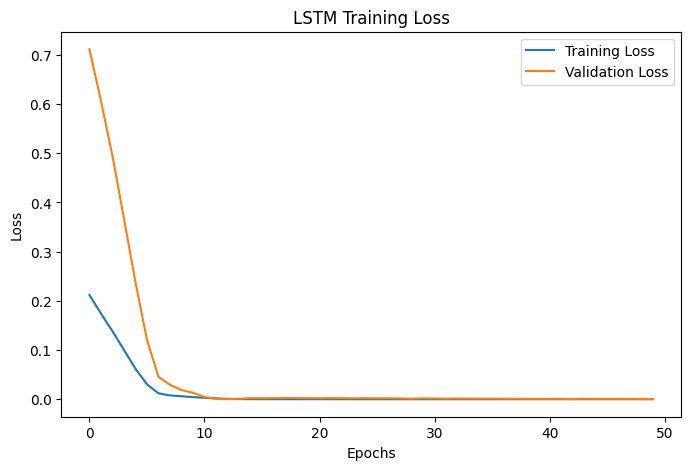

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step
Test RMSE: 49.10
 r2-score (closer to 1, more the model is preferred) : 0.8659581754137808


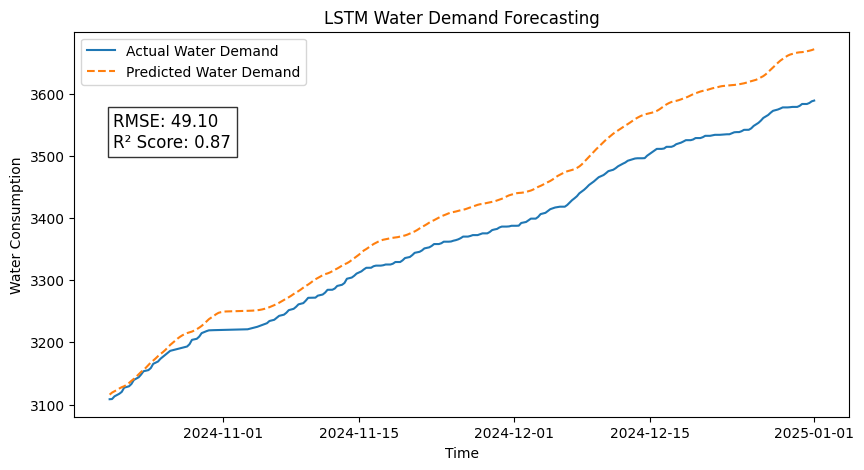


Training LSTM with Adagrad optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.2290 - val_loss: 0.7811
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2017 - val_loss: 0.7318
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1868 - val_loss: 0.6942
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1695 - val_loss: 0.6628
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1544 - val_loss: 0.6352
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1419 - val_loss: 0.6098
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1392 - val_loss: 0.5856
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1277 - val_loss: 0.5618
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1150 - val_loss: 0.5377
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1098 - val_loss: 0.5149
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1077 - val_loss: 0.4930
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0930 - val_

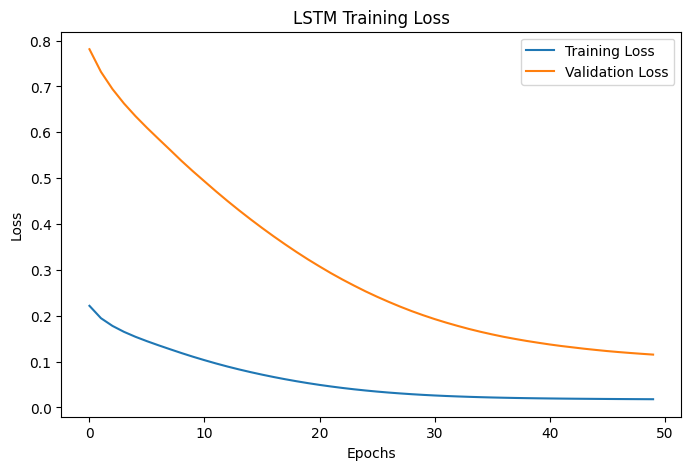

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step
Test RMSE: 826.84
 r2-score (closer to 1, more the model is preferred) : -37.016963610917664


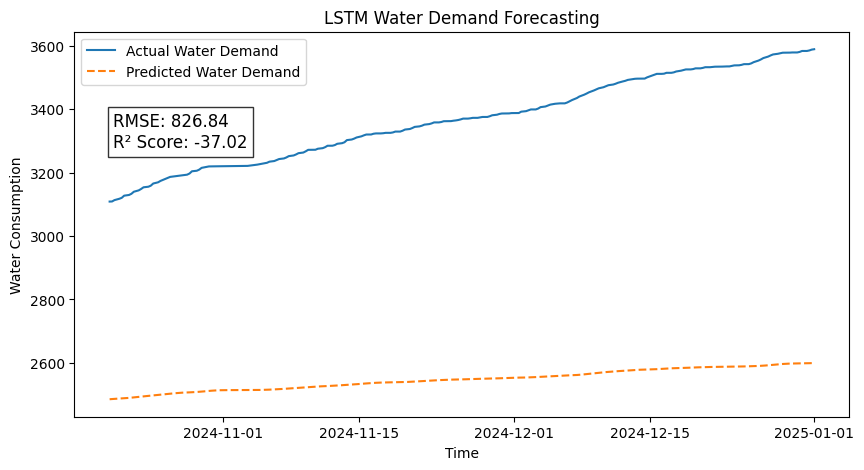


Training LSTM with Adadelta optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.2519 - val_loss: 0.8788
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2417 - val_loss: 0.8774
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2487 - val_loss: 0.8760
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2360 - val_loss: 0.8745
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2386 - val_loss: 0.8729
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2454 - val_loss: 0.8713
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2430 - val_loss: 0.8697
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2370 - val_loss: 0.8680
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2429 - val_loss: 0.8662
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2402 - val_loss: 0.8644
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2451 - val_loss: 0.8626
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2413 - val_l

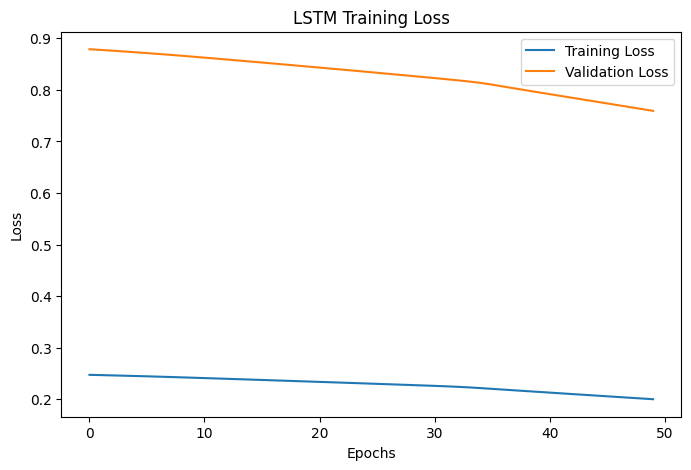

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
Test RMSE: 2122.12
 r2-score (closer to 1, more the model is preferred) : -249.41925755838358


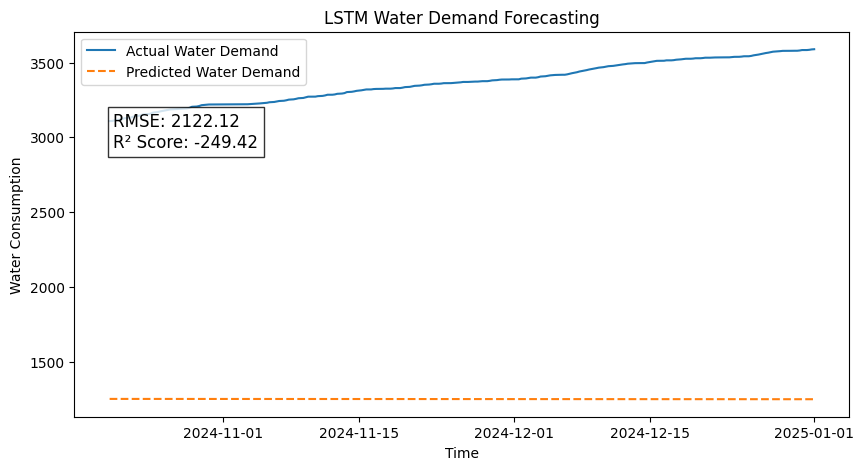

In [9]:
for name, opt in optimizers.items():
    print(f"\nTraining LSTM with {name} optimizer...")
    lstm_model = build_lstm_model(opt)
    history_lstm = lstm_model.fit(X_train, y_train, 
                              epochs=50, 
                              batch_size=32, 
                              validation_data=(X_test, y_test), 
                              verbose=1)
    # Plot for LSTM
    plot_training_loss(history_lstm, "LSTM")
    pred(lstm_model,X_test,y_test,scaler,original_timestamps)